kR_pr = 0.9516844649799999
Boundary residual: min/max/RMS = -2.316591610446976 2.282225350107566 0.3399532482102023


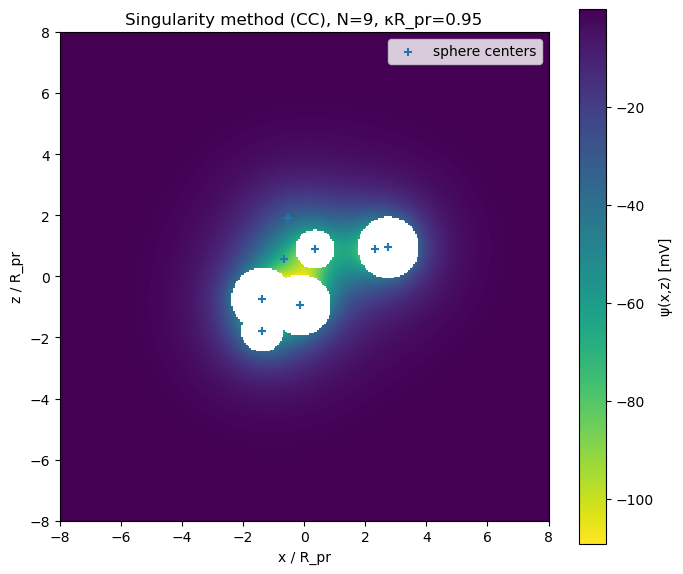

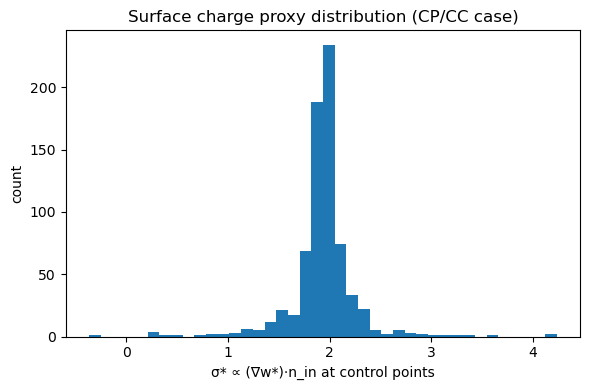

C:\Users\dsapa\AppData\Local\Temp\ipykernel_37960\643298077.py:621: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


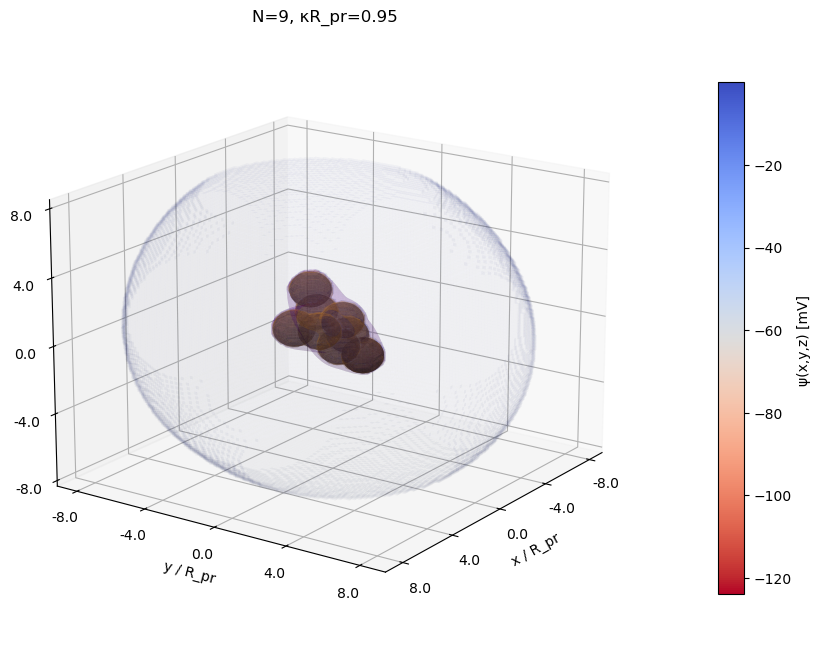


--- Potential statistics on the hypothetical sphere r = Rg ---
Rg/Rpr = 2.273747
psī(Rg) = -39.9903 mV
σψ(Rg)   = 10.0505 mV
σψ/|psī| = 0.2513

psi_iso = -30.118089 mV


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done  83 out of 100 | elapsed: 17.3min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 18.5min remaining:  1.2min



--- Ensemble results (100 RLCA clusters) ---
Average Rg/Rpr        = 2.369289
Average psī(Rg)       = -36.248016 mV
Average σψ(Rg)        = 9.462749 mV
psi_iso(ensemble mean)= -30.118089 mV
BC residual RMS (mean)= 6.179e-01


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 19.4min finished


In [ ]:
## Singularity Method Simulations ##
 
## Singularity Method Simulations for Cluster-Cluster Electrostatic Potential (version 8.2) ##

## D.Sapalidis, Zurich, 12.01.2026 ##


import numpy as np
import matplotlib.pyplot as plt


# ----------------------------
# 0) User parameters
# ----------------------------
APPROXIMATION = "CC"        # "CP" (constant potential) or "CC" (constant charge)

R_pr = 8.60e-9              # primary particle radius [m]
kappa = 1.106609843e8       # Debye parameter [1/m]

psi0_iso = -0.0711          # isolated primary particle surface potential [V] (used only if CP)
sigma0_iso = -0.004744641   # isolated primary particle surface charge density [C/m^2] (used only if CC)

eps0 = 8.8541878128e-12     # vacuum permittivity [F/m]
eps_r = 78.4                # relative permittivity of medium (water at ~25 °C)
eps_m = eps_r * eps0        # medium permittivity [F/m]

N = 9                       # RLCA cluster size (change here)
seed = 12                   # seed for RLCA geometry

noc = 40                    # off-center singularities per particle
ncp = 80                    # control points per particle
rocfac = 0.5                # off-center shell radius in units of R_pr

# 2D plot
L_plot = 8.0                # half-size of plot window in units of R_pr
grid_n = 301                # grid resolution

# ----------------------------
# 1) Point sets on sphere
# ----------------------------
def fibonacci_sphere(n):
    """
    Generate n approximately uniformly distributed points on a unit sphere
    using the Fibonacci spiral method.
    """
    i = np.arange(n)
    phi = (1 + 5**0.5) / 2
    ga = 2*np.pi*(1 - 1/phi)
    z = 1 - 2*(i + 0.5)/n
    r = np.sqrt(np.clip(1 - z*z, 0, 1))
    theta = ga * i
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return np.stack([x, y, z], axis=1)

# ----------------------------
# 2) Build a simple RLCA cluster
# ----------------------------
def build_rlca_cluster(
    N_target,
    R_pr,
    p_stick=1e-3,
    L_box_factor=8.0,
    seed=0
):
    """
    RLCA cluster generator.
    - radius = R_pr (meters)
    - box size = L_box_factor * (2*R_pr)
    Starts aggregation already from N=2.
    """
    rng = np.random.default_rng(seed)
    D = 2.0 * R_pr              # particle diameter
    L_box = L_box_factor * D    # box side length

    def min_image(delta):
        return delta - L_box * np.round(delta / L_box)

    # start with 2 touching particles
    pos0 = np.array([0.0, 0.0, 0.0])
    pos1 = np.array([D,   0.0, 0.0])

    clusters = [
        {"pos": pos0.reshape(1, 3), "mass": 1},
        {"pos": pos1.reshape(1, 3), "mass": 1},
    ]

    if N_target == 2:
        return np.vstack([pos0, pos1])

    # add monomers randomly
    positions = [pos0, pos1]

    def random_non_overlapping():
        while True:
            p = rng.uniform(0.0, L_box, size=3)
            ok = True
            for q in positions:
                dq = min_image(p - q)
                if np.linalg.norm(dq) < D:
                    ok = False
                    break
            if ok:
                return p

    for _ in range(2, N_target):
        p = random_non_overlapping()
        positions.append(p)
        clusters.append({"pos": p.reshape(1, 3), "mass": 1})

    dirs = np.array([
        [ 1, 0, 0],
        [-1, 0, 0],
        [ 0, 1, 0],
        [ 0,-1, 0],
        [ 0, 0, 1],
        [ 0, 0,-1],
    ], float)

    step_len = D
    max_iter = 3_000_000

    for _ in range(max_iter):
        if len(clusters) == 1:
            break

        masses = np.array([c["mass"] for c in clusters], float)
        probs = masses**(-1/2.09)
        probs /= probs.sum()

        i = rng.choice(len(clusters), p=probs)
        cl = clusters[i]

        step = dirs[rng.integers(0, 6)] * step_len
        new_pos = (cl["pos"] + step) % L_box

        collided = None
        min_d2 = np.inf

        for j, other in enumerate(clusters):
            if j == i:
                continue

            diff = min_image(new_pos[:, None, :] - other["pos"][None, :, :])
            d2 = np.sum(diff**2, axis=2)
            d2_min_local = d2.min()
            if d2_min_local < D**2:
                if d2_min_local < min_d2:
                    min_d2 = d2_min_local
                    collided = j

        if collided is not None:
            if rng.random() < p_stick:
                cl["pos"] = new_pos
                other = clusters[collided]
                cl["pos"] = np.vstack([cl["pos"], other["pos"]])
                cl["mass"] += other["mass"]

                if collided > i:
                    del clusters[collided]
                else:
                    del clusters[collided]
                    clusters[i-1] = cl
        else:
            cl["pos"] = new_pos

    if len(clusters) != 1:
        print("Warning: RLCA incomplete; returning largest-by-mass cluster.")
        idx_max = int(np.argmax([c["mass"] for c in clusters]))
        pos = clusters[idx_max]["pos"]
    else:
        pos = clusters[0]["pos"]

    n = pos.shape[0]

    adj = [[] for _ in range(n)]
    for a in range(n):
        da = min_image(pos[a] - pos)
        d2 = np.sum(da*da, axis=1)
        neigh = np.where((d2 > 0.0) & (d2 <= (D*1.01)**2))[0]
        for b in neigh:
            adj[a].append(int(b))

    unwrapped = np.full_like(pos, np.nan)
    unwrapped[0] = pos[0]
    stack = [0]
    while stack:
        u = stack.pop()
        for v in adj[u]:
            if np.isfinite(unwrapped[v]).all():
                continue
            dv = min_image(pos[v] - pos[u])
            unwrapped[v] = unwrapped[u] + dv
            stack.append(v)

    bad = np.isnan(unwrapped[:, 0])
    if np.any(bad):
        unwrapped[bad] = pos[bad]

    return unwrapped

# build RLCA cluster for the chosen N
centers_phys = build_rlca_cluster(
    N_target=N,
    R_pr=R_pr,
    p_stick=1e-3,
    L_box_factor=8.0,
    seed=seed
)

# convert to dimensionless centers (units of R_pr) and recenter at center of mass
centers_dimless = centers_phys / R_pr
r_cm = centers_dimless.mean(axis=0)
centers = centers_dimless - r_cm      # cluster centred at origin
kR_pr = kappa * R_pr                  # dimensionless κR_pr

# convert between psi0 and sigma0 using isolated-sphere relation
psi_iso_from_sigma = sigma0_iso / (eps_m * (kappa + 1.0 / R_pr))
sigma_from_psi_iso = psi0_iso * eps_m * (kappa + 1.0 / R_pr)

if APPROXIMATION.upper().strip() == "CP":
    psi0_scale = psi0_iso
elif APPROXIMATION.upper().strip() == "CC":
    psi0_scale = psi_iso_from_sigma
else:
    raise ValueError("APPROXIMATION must be 'CP' or 'CC'.")

# ----------------------------
# 3) Singularity method (CP or CC boundary condition)
#    w*(r) = Σ q* exp(-kR_pr R*) / R*
#    CP: enforce w*=1 at control points on each particle surface
#    CC: enforce n·∇w* = κa+1 at control points (constant charge)
# ----------------------------
def solve_singularity_cp(centers, kR_pr, noc=40, ncp=80, rocfac=0.5):
    """
    Constant Potential (CP) boundary condition solver.
    """
    Nloc = len(centers)
    dirs_oc = fibonacci_sphere(noc)
    dirs_cp = fibonacci_sphere(ncp)

    # Off-centre singularity locations inside each sphere
    sing_pos = np.vstack([c + rocfac*dirs_oc for c in centers])

    # Control points on each sphere surface (dimensionless)
    cp_pos = np.vstack([c + 1.0*dirs_cp for c in centers])

    # Inward normals at control points (pointing toward sphere center)
    cp_norm_in = np.vstack([-dirs_cp for _ in centers])

    # Fixed central singularity per sphere: q_c* = exp(kR_pr)
    q_c = np.exp(kR_pr)

    # 1 - sum of central contributions from all spheres at each control point
    d_c = np.linalg.norm(cp_pos[:, None, :] - centers[None, :, :], axis=2)
    w_c = q_c * np.exp(-kR_pr * d_c) / d_c
    b = 1.0 - np.sum(w_c, axis=1)           # (M,)

    # Matrix A: contributions from each off-centre singularity
    d_s = np.linalg.norm(cp_pos[:, None, :] - sing_pos[None, :, :], axis=2)
    A = np.exp(-kR_pr * d_s) / d_s

    # Least-squares solve
    q_oc, *_ = np.linalg.lstsq(A, b, rcond=None)

    # Boundary residual: (w_c + A q_oc) - 1
    residual = (np.sum(w_c, axis=1) + A @ q_oc) - 1.0
    return q_oc, sing_pos, cp_pos, cp_norm_in, residual


def solve_singularity_cc(centers, kR_pr, noc=40, ncp=80, rocfac=0.5, eps_safe=1e-12):
    """
    Constant Charge (CC) boundary condition solver.
    Enforces n·∇ψ* = S* = κa + 1 at control points.
    """
    Nloc = len(centers)
    dirs_oc = fibonacci_sphere(noc)
    dirs_cp = fibonacci_sphere(ncp)

    # Off-centre singularity locations inside each sphere
    sing_pos = np.vstack([c + rocfac*dirs_oc for c in centers])

    # Control points on each sphere surface (dimensionless)
    cp_pos   = np.vstack([c + 1.0*dirs_cp   for c in centers])

    # Inward normals at control points (pointing toward sphere center)
    cp_norm_in = np.vstack([-dirs_cp for _ in centers])

    # Fixed central singularity per sphere: q_c* = exp(kR_pr)
    q_c = np.exp(kR_pr)

    # CC boundary condition in dimensionless form: -∂w*/∂n = (kR_pr + 1)
    S_star = kR_pr + 1.0

    # Vector from singularities to control points and distances
    Rvec_s = cp_pos[:, None, :] - sing_pos[None, :, :]
    d_s = np.linalg.norm(Rvec_s, axis=2)
    d_s = np.maximum(d_s, eps_safe)
    dot_s = np.sum(Rvec_s * cp_norm_in[:, None, :], axis=2)

    # Matrix A: normal-derivative contributions from off-centre singularities
    # ∇[q e^{-kR R}/R] · n = - q e^{-kR R} (kR R + 1) * (R·n) / R^3
    A = -np.exp(-kR_pr * d_s) * (kR_pr * d_s + 1.0) * dot_s / (d_s**3)

    # Vector from centers to control points
    Rvec_c = cp_pos[:, None, :] - centers[None, :, :]
    d_c = np.linalg.norm(Rvec_c, axis=2)
    d_c = np.maximum(d_c, eps_safe)
    dot_c = np.sum(Rvec_c * cp_norm_in[:, None, :], axis=2)

    # Normal derivative from central singularities
    ngrad_c_per_unit = -np.exp(-kR_pr * d_c) * (kR_pr * d_c + 1.0) * dot_c / (d_c**3)
    ngrad_c = q_c * np.sum(ngrad_c_per_unit, axis=1)

    # Right-hand side: S* minus central contributions
    b = S_star - ngrad_c

    # Least-squares solve
    q_oc, *_ = np.linalg.lstsq(A, b, rcond=None)

    # Boundary residual
    residual = (ngrad_c + A @ q_oc) - S_star
    return q_oc, sing_pos, cp_pos, cp_norm_in, residual


def solve_singularity(centers, kR_pr, mode="CP", noc=40, ncp=80, rocfac=0.5):
    """
    Wrapper to select CP or CC boundary condition solver.
    """
    mode = mode.upper().strip()
    if mode == "CP":
        return solve_singularity_cp(centers, kR_pr=kR_pr, noc=noc, ncp=ncp, rocfac=rocfac)
    elif mode == "CC":
        return solve_singularity_cc(centers, kR_pr=kR_pr, noc=noc, ncp=ncp, rocfac=rocfac)
    else:
        raise ValueError("BC mode must be 'CP' or 'CC'.")


q_oc, sing_pos, cp_pos, cp_norm_in, residual = solve_singularity(
    centers, kR_pr=kR_pr, mode=APPROXIMATION, noc=noc, ncp=ncp, rocfac=rocfac
)

print("kR_pr =", kR_pr)
print("Boundary residual: min/max/RMS =",
      residual.min(), residual.max(), np.sqrt(np.mean(residual**2)))

# ----------------------------
# 4) Evaluate potential field w* on arbitrary points (dimensionless)
# ----------------------------
def potential_wstar(points, centers, sing_pos, q_oc, kR_pr):
    """
    Evaluate the dimensionless potential w*(r) at given points.
    w*(r) = Σ_j q_j * exp(-kR_pr R_j) / R_j
    """
    q_c = np.exp(kR_pr)

    d_c = np.linalg.norm(points[:, None, :] - centers[None, :, :], axis=2)
    w_c = q_c * np.exp(-kR_pr * d_c) / d_c

    d_s = np.linalg.norm(points[:, None, :] - sing_pos[None, :, :], axis=2)
    w_s = (np.exp(-kR_pr * d_s) / d_s) @ q_oc

    return np.sum(w_c, axis=1) + w_s

# ----------------------------
# 5) Surface charge proxy: σ* ∝ (∇w*)·n_in at control points
#    (gradient of Yukawa singularity)
# ----------------------------
def grad_wstar(points, centers, sing_pos, q_oc, kR_pr, eps_safe=1e-12):
    """
    ∇w*(r) for w*(r) = Σ_j q_j * exp(-kR_pr R_j) / R_j  (dimensionless units).
    Returns gradient with respect to dimensionless coordinates.
    """
    grad = np.zeros_like(points, dtype=float)

    # central singularity per sphere: strength q_c = exp(kR_pr)
    q_c = np.exp(kR_pr)

    # helper: gradient of Yukawa kernel q * exp(-kR R)/R
    # ∇[q e^{-kR R}/R] = - q e^{-kR R} (kR R + 1) * Rvec / R^3
    def add_yukawa_sources(src_pos, src_q):
        nonlocal grad
        for s, q in zip(src_pos, src_q):
            Rvec = points - s
            R = np.linalg.norm(Rvec, axis=1)
            R = np.maximum(R, eps_safe)
            fac = q * np.exp(-kR_pr * R) * (kR_pr * R + 1.0) / (R**3)
            grad -= Rvec * fac[:, None]

    # central sources (one per particle)
    add_yukawa_sources(centers, np.full(len(centers), q_c, dtype=float))

    # off-centre sources (use fitted q_oc)
    add_yukawa_sources(sing_pos, q_oc.astype(float))
    return grad

sigma_star = np.sum(grad_wstar(cp_pos, centers, sing_pos, q_oc, kR_pr) * cp_norm_in, axis=1)

# ----------------------------
# 6) 2D slice (y=0 plane) of the potential
# ----------------------------
x = np.linspace(-L_plot, L_plot, grid_n)
z = np.linspace(-L_plot, L_plot, grid_n)
X, Z = np.meshgrid(x, z)
Y = np.zeros_like(X)
pts = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

wstar = potential_wstar(pts, centers, sing_pos, q_oc, kR_pr).reshape(grid_n, grid_n)

psi_mV = 1e3 * psi0_scale * wstar

# Mask inside spheres for clarity
mask = np.zeros((grid_n, grid_n), dtype=bool)
for c in centers:
    R2 = (X - c[0])**2 + (Z - c[2])**2 + (Y - c[1])**2
    mask |= (R2 <= 1.0**2)      # radius = 1 in units of R_pr
psi_mV_masked = np.ma.array(psi_mV, mask=mask)

plt.figure(figsize=(7, 6))
plt.imshow(
    psi_mV_masked,
    origin="lower",
    extent=[x.min(), x.max(), z.min(), z.max()],
    aspect="equal",
    cmap="viridis_r"
)

plt.colorbar(label="ψ(x,z) [mV]")
plt.scatter(centers[:,0], centers[:,2], s=40, marker="+", label="sphere centers")
plt.xlabel("x / R_pr")
plt.ylabel("z / R_pr")

plt.title(f"Singularity method ({APPROXIMATION}), N={N}, κR_pr={kR_pr:.2f}")

plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 7) Quick diagnostic: surface-charge proxy histogram
# ----------------------------
plt.figure(figsize=(6, 4))
plt.hist(sigma_star, bins=40)
plt.xlabel("σ* ∝ (∇w*)·n_in at control points")
plt.ylabel("count")
plt.title("Surface charge proxy distribution (CP/CC case)")
plt.tight_layout()
plt.show()

# Rg of cluster of identical spheres using center positions only (in units of R_pr).
def radius_of_gyration_solid_spheres_dimless(centers_dimless):
    r_cm = np.mean(centers_dimless, axis=0)
    Rg_centers_sq = np.mean(np.sum((centers_dimless - r_cm)**2, axis=1))  # (Rg_centers/Rpr)^2
    return np.sqrt(Rg_centers_sq + 3.0/5.0)

def sample_sphere_points(center, radius, n):
    dirs = fibonacci_sphere(n)
    return center + radius * dirs, dirs

# Evaluate ψ on the surface of the hypothetical sphere of radius Rg: ψ(Rg) and σψ(Rg)
def psi_stats_on_Rg_sphere(centers_dimless, sing_pos, q_oc, kR_pr, psi0_iso_V, n_surf=6000, mode=APPROXIMATION):
    
    r_cm = np.mean(centers_dimless, axis=0)
    Rg_dimless = radius_of_gyration_solid_spheres_dimless(centers_dimless)
    pts, _ = sample_sphere_points(r_cm, Rg_dimless, n_surf)

    d2 = np.sum((pts[:, None, :] - centers_dimless[None, :, :])**2, axis=2)
    inside = np.any(d2 <= 1.0**2, axis=1)

    wstar_vals = potential_wstar(pts, centers_dimless, sing_pos, q_oc, kR_pr)
    psi_vals_V = psi0_iso_V * wstar_vals

    if mode.upper().strip() == "CP":
        psi_vals_V[inside] = psi0_iso_V

    
    psi_bar_V = np.mean(psi_vals_V)
    
    
    filter_magnitude = 0.5 * np.abs(psi_bar_V)
    bound_low = psi_bar_V - filter_magnitude   
    bound_high = psi_bar_V + filter_magnitude  
    
    
    mask = (psi_vals_V >= min(bound_low, bound_high)) & (psi_vals_V <= max(bound_low, bound_high))
    psi_filtered = psi_vals_V[mask]
    
    
    psi_std_V = np.std(psi_filtered, ddof=1) if len(psi_filtered) >= 2 else np.nan

    return {
        "Rg_dimless": float(Rg_dimless),
        "psi_bar_V": float(psi_bar_V),
        "psi_std_V": float(psi_std_V),
        "psi_bar_mV": 1e3 * psi_bar_V,
        "psi_std_mV": 1e3 * psi_std_V,
        "n_surf_total": int(n_surf),
        "n_surf_internal": int(np.sum(inside)),
        "n_surf_used": int(np.sum(mask)),
    }



# ============================================================
# 8) 3-D Plot
# ============================================================
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes

L3D = L_plot
ng = 90
clip_lo, clip_hi = 0, 100
occupancy_percentile = 20
alpha_min, alpha_max = 0.02, 0.28

# spheres look
sphere_alpha = 0.45
sphere_mesh_u = 70
sphere_mesh_v = 35

# iso-shells
iso_levels_frac = (0.25, 0.55)      # fractions of clipped range [vmin,vmax]
iso_alpha = (0.12, 0.20)            # transparency of the two shells

# build 3D grid
g = np.linspace(-L3D, L3D, ng)
X3, Y3, Z3 = np.meshgrid(g, g, g, indexing="ij")
pts3 = np.stack([X3.ravel(), Y3.ravel(), Z3.ravel()], axis=1)

# evaluate potential (mV)
w3 = potential_wstar(pts3, centers, sing_pos, q_oc, kR_pr).reshape(ng, ng, ng)

psi3_mV = 1e3 * psi0_scale * w3

# mask inside spheres
mask3 = np.zeros((ng, ng, ng), dtype=bool)
for c in centers:
    mask3 |= ((X3 - c[0])**2 + (Y3 - c[1])**2 + (Z3 - c[2])**2) <= 1.0**2

psi3 = np.array(psi3_mV, copy=True)
psi3[mask3] = np.nan

valid = psi3[np.isfinite(psi3)]
if valid.size == 0:
    raise RuntimeError("3D plot: no valid points (everything masked).")

# normalization
vmin = np.percentile(valid, clip_lo)
vmax = np.percentile(valid, clip_hi)
if vmax <= vmin:
    vmax = vmin + 1e-12

psi_clip = np.clip(psi3, vmin, vmax)
norm = (psi_clip - vmin) / (vmax - vmin)

thr = np.percentile(valid, 100 - occupancy_percentile)
filled = np.isfinite(psi3) & (psi3 <= thr)

# contrast
gamma = 0.55
norm_g = np.nan_to_num(norm, nan=0.0) ** gamma

cmap = plt.cm.coolwarm_r
rgba = cmap(norm_g)
rgba[..., 3] = alpha_min + (alpha_max - alpha_min) * (1 - norm_g)
rgba[~filled] = (0, 0, 0, 0)

fig = plt.figure(figsize=(11, 8))
ax = fig.add_subplot(111, projection="3d")

ax.voxels(filled, facecolors=rgba, edgecolor="none")

tick_pos = np.linspace(0, ng - 1, 5)
tick_lab = [f"{v:.1f}" for v in np.linspace(-L3D, L3D, 5)]
ax.set_xticks(tick_pos); ax.set_xticklabels(tick_lab)
ax.set_yticks(tick_pos); ax.set_yticklabels(tick_lab)
ax.set_zticks(tick_pos); ax.set_zticklabels(tick_lab)

ax.set_xlabel("x / R_pr")
ax.set_ylabel("y / R_pr")
ax.set_zlabel("z / R_pr")

# particle spheres (in index coordinates)
u = np.linspace(0, 2*np.pi, sphere_mesh_u)
v = np.linspace(0, np.pi, sphere_mesh_v)
su = np.outer(np.cos(u), np.sin(v))
sv = np.outer(np.sin(u), np.sin(v))
sw = np.outer(np.ones_like(u), np.cos(v))

# conversion: physical coord -> voxel index coord
scale = (ng - 1) / (2 * L3D)
shift = (ng - 1) / 2

for c in centers:
    ax.plot_surface(
        (c[0] + su) * scale + shift,
        (c[1] + sv) * scale + shift,
        (c[2] + sw) * scale + shift,
        linewidth=0,
        antialiased=True,
        shade=True,
        color=(0.20, 0.20, 0.20),
        alpha=sphere_alpha
    )

# 2 iso-potential shells via marching cubes
psi_mc = np.where(np.isfinite(psi_clip), psi_clip, vmin)

iso_vals = [vmax - f * (vmax - vmin) for f in iso_levels_frac]
iso_cols = [plt.cm.plasma(0.20), plt.cm.plasma(0.85)]

for iso_val, col, a in zip(iso_vals, iso_cols, iso_alpha):
    verts, faces, _, _ = marching_cubes(psi_mc, level=iso_val)
    ax.plot_trisurf(
        verts[:, 0], verts[:, 1], faces, verts[:, 2],
        color=col, alpha=a, linewidth=0, antialiased=True, shade=True
    )

# colorbar in mV
mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_array(valid)
mappable.set_clim(vmin, vmax)
cb = plt.colorbar(mappable, ax=ax, fraction=0.03, pad=0.1)
cb.set_label(f"ψ(x,y,z) [mV] ")

ax.set_title(f"N={N}, κR_pr={kR_pr:.2f}")
ax.view_init(elev=18, azim=35)
plt.tight_layout()
plt.show()


stats = psi_stats_on_Rg_sphere(
    centers_dimless=centers,      
    sing_pos=sing_pos,
    q_oc=q_oc,
    kR_pr=kR_pr,
    psi0_iso_V=psi0_scale,
    n_surf=6000,
    mode=APPROXIMATION,
)


# ============================================================
# 9) Potential statistics
# ============================================================
print("\n--- Potential statistics on the hypothetical sphere r = Rg ---")
print(f"Rg/Rpr = {stats['Rg_dimless']:.6f}")
print(f"psī(Rg) = {stats['psi_bar_mV']:.4f} mV")
print(f"σψ(Rg)   = {stats['psi_std_mV']:.4f} mV")
print(f"σψ/|psī| = {stats['psi_std_V']/abs(stats['psi_bar_V']):.4f}"
      if stats['psi_bar_V'] != 0 else "σψ/|psī| = inf")

psi_iso_single = psi_iso_from_sigma if APPROXIMATION.upper().strip() == "CC" else psi0_iso
print(f"\npsi_iso = {1e3 * psi_iso_single:.6f} mV")


# ============================================================
# 10) Ensemble over multiple RLCA clusters 
# ============================================================
import os
import numpy as np

# Multiprocessing
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

try:
    from joblib import Parallel, delayed
except ImportError as e:
    raise ImportError("joblib is required for this section. Install with: pip install joblib") from e


def _run_one_cluster(seed_val: int):
    """
    One RLCA geometry + singularity solve + stats. Runs in a separate process via joblib(loky).
    
    """
    try:
        # 1) Build cluster
        centers_phys_i = build_rlca_cluster(
            N_target=N,
            R_pr=R_pr,
            p_stick=1e-3,
            L_box_factor=8.0,
            seed=seed_val
        )

        # 2) Normalize geometry
        centers_dimless_i = centers_phys_i / R_pr
        centers_i = centers_dimless_i - centers_dimless_i.mean(axis=0)

        # 3) Solve singularity system
        q_oc_i, sing_pos_i, cp_pos_i, cp_norm_in_i, residual_i = solve_singularity(
            centers_i, kR_pr=kR_pr, mode=APPROXIMATION, noc=noc, ncp=ncp, rocfac=rocfac
        )

        # 4) Stats on Rg sphere
        stats_i = psi_stats_on_Rg_sphere(
            centers_dimless=centers_i,
            sing_pos=sing_pos_i,
            q_oc=q_oc_i,
            kR_pr=kR_pr,
            psi0_iso_V=psi0_scale,
            n_surf=6000,
            mode=APPROXIMATION,
        )

        # 5) psi_iso  
        psi_iso_i = psi_iso_from_sigma if APPROXIMATION.upper().strip() == "CC" else psi0_iso

        # Diagnostics
        stats_i["bc_residual_rms"] = float(np.sqrt(np.mean(residual_i**2)))
        stats_i["bc_residual_min"] = float(np.min(residual_i))
        stats_i["bc_residual_max"] = float(np.max(residual_i))

        return stats_i, float(psi_iso_i)

    except Exception as err:
        raise RuntimeError(f"Cluster failed for seed={seed_val}") from err


# run ensemble 
n_clusters = 100
seed0 = seed
seeds = [seed0 + i for i in range(n_clusters)]

# batch_size: >1 reduces scheduling overhead; tune (2-10) depending on runtime per task
results = Parallel(
    n_jobs=-1,
    backend="loky",
    batch_size=4,
    verbose=10  # set to 0 to silence
)(
    delayed(_run_one_cluster)(s) for s in seeds
)

# summarize
Rg_arr = np.array([r[0]["Rg_dimless"] for r in results], dtype=float)
psi_bar_mV_arr = np.array([r[0]["psi_bar_mV"] for r in results], dtype=float)
psi_std_mV_arr = np.array([r[0]["psi_std_mV"] for r in results], dtype=float)
n_used_arr = np.array([r[0]["n_surf_used"] for r in results], dtype=float)
n_masked_arr = np.array([r[0]["n_surf_internal"] for r in results], dtype=float)
psi_iso_arr = np.array([r[1] for r in results], dtype=float)

bc_rms_arr = np.array([r[0].get("bc_residual_rms", np.nan) for r in results], dtype=float)

print("\n--- Ensemble results (100 RLCA clusters) ---")
print(f"Average Rg/Rpr        = {np.nanmean(Rg_arr):.6f}")
print(f"Average psī(Rg)       = {np.nanmean(psi_bar_mV_arr):.6f} mV")
print(f"Average σψ(Rg)        = {np.nanmean(psi_std_mV_arr):.6f} mV")
print(f"psi_iso(ensemble mean)= {1e3*np.nanmean(psi_iso_arr):.6f} mV")
print(f"BC residual RMS (mean)= {np.nanmean(bc_rms_arr):.3e}")

